# import libs

In [8]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.pyplot.rc('text', usetex=True)
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# set parameters

In [2]:
#--- set dynamic parameters
temp = confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


# Parse Lammps dump file

In [3]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = 1) #sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

output dump file=14.050671100616455 s
parsing dumpFile/dump.xyz
elapsed time=0.10397100448608398 s
time steps: dict_keys([0, 1])


,id,type,x,y,z
0,1,1,14.494469,21.506977,10.986848
1,2,1,12.740991,7.480801,23.259970
2,3,1,5.727233,9.233570,10.986738
3,4,1,18.002977,7.478290,3.974792
4,5,1,10.987465,0.468488,3.974792


# Energy

In [4]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,
                 events_directory,evlist_directory,
                 lmpData,
                 nmax = sys.maxsize,
                 verbose=False):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        #--- soap parameters
        self.species = ['Ni'] #'Ni Co Cr'.split()
        self.r_cut = 4.1
        self.n_max = 8
        self.l_max = 6
        #
        self.nmax = np.min(np.array([nmax,sys.maxsize]))
        self.verbose = verbose
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
#        self.catalog          = self.ParseEvList_dir()
        self.diffusionPaths   = self.ParseDiffusionPath()
        
        
    def ParseEvents_dir(self):
        '''
        return energy barriers associated with hopping events
        '''
        if self.verbose:
            print('parsing events ...')
        files = os.listdir(self.events_dir)
        d=[]
        count = 0
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
                    #
                    if count > self.nmax:
                        break
                    count += 1
                except:
#                    traceback.print_exc()
                    continue
            
        #--- extract types
        df       = self.lmpData
        atom_ids = d[:,1]
        types    = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    @staticmethod
    def ReadConfigurationFile(dumpFile, outpt, outpt_headers):
        '''
        return displacements
        '''
#        !rm outpt outpt_headers
        lib_path = confParser['input files']['lib_path']

        #--- parse dump: call ovito
        !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers

        #--- parse dump files
        lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        lmpData.GetCords( ncount = sys.maxsize)

        #--- disp
        fileCurr = fileRef = outpt #'dumpFile/dump.xyz'
        outpt = 'disp.xyz'
#        !rm $outpt

        #--- call ovito
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))

        #--- parse disp files
        lmpDisp = lp.ReadDumpFile( outpt )
        lmpDisp.GetCords( ncount = sys.maxsize )
        return lmpDisp

    @staticmethod
    def GetEventid(filestr):
        '''
        extract event id from input string
        '''
        n = len(filestr)
        return int(filestr[5:n-4])
    
    def ParseDiffusionPath(self):
        '''
        return diffusion path corresponding to hopping events
        '''
        if self.verbose:
            print('parsing ParseDiffusionPath ...')
        disps = {}
        count = 0
        files = os.listdir(self.events_dir)
        self.events_id_energy
        for event_id in list(map(int,self.events_id_energy.event_id)):
#        for sfile in files:
#            if '.xyz' in sfile: #--- skip .xyz files 
#                try:
                    dumpFile = '%s/event%s.xyz'%(self.events_dir,event_id) #--- open file
                    #         outpt = 'dumpFile/dump.xyz'
#                    event_id = EnergyBarrier.GetEventid(sfile)
                    disps[event_id] = \
                    EnergyBarrier.ReadConfigurationFile(dumpFile, 'dump.xyz', 'calcResults.txt')
                    if self.verbose:
                        print('event_id=%s'%(event_id))
                    #
                    if count > self.nmax:
                        break
                    count += 1
#                 except:
#                     traceback.print_exc()
#                     continue
        return disps
    
    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

    def SetDescriptors(self, event_id):
        
        positions = self.diffusionPaths[event_id].coord_atoms_broken[0]['x y z'.split()]

        #--- convert to lammps data file
        atom = lp.Atoms(**self.diffusionPaths[event_id].coord_atoms_broken[0].to_dict(orient='series'))
        box = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))
        wd = lp.WriteDataFile(atom, box, {1:1,2:1,3:1})
        wd.Write('lammps.dat')

        center_atom_type = self.diffusionPaths[event_id].coord_atoms_broken[0]['type'].iloc[-1]
        
        #--- load configuration
        atoms = ase.io.read("lammps.dat",format="lammps-data",style='atomic')


        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=False,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

        


        # set atomic numbers for each species
        types=atoms.get_atomic_numbers()
        numbers = list(map(lambda x:soap.index_to_atomic_number[x-1],atoms.get_atomic_numbers()))
        atoms.set_atomic_numbers(numbers)
        numbers = atoms.get_atomic_numbers()
        #assert soap.check_atomic_numbers(atoms.get_atomic_numbers())

        #--- center atom is the last entry
        soap_descriptors = soap.create( atoms,centers=[atoms.get_number_of_atoms()-1])
        
#        pdb.set_trace()

        count = 0
        nspecies = len(self.species)
        for Z in range(nspecies):#atoms.get_atomic_numbers():
            for Zprime in range(nspecies): #atoms.get_atomic_numbers():
                for l in range(self.l_max+1):
                    for n in range(self.n_max):
                        for nprime in range(self.n_max):
                            if nprime >= n and Zprime >= Z:
                                count += 1
        assert count == soap_descriptors[0].shape[0], 'count = %s, soap.shape=%s'%(count,soap_descriptors[0].shape[0])

        return soap_descriptors[0]
    
    
    def SetDescriptorsMultipleEvents(self):
        events = list(self.diffusionPaths.keys())
        self.descriptors = np.c_[list(map(lambda x:self.SetDescriptors(x), events))]
        
    def DefectFreeCrystal(self):
        '''
        Return a crystalline structure
        '''
        # Lets create an FCC(111) surface
        a=2.5*2**0.5
        atoms = ase.build.fcc100(
            "Ni",
             (4,4,4),
            a=a,
    #        vacuum=10,
            periodic=True
        )

        lammpsdata.write_lammps_data('junk.dat', atoms )
        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

                #--- center atom is the last entry
        self.descriptors_defect_free = soap.create( atoms,centers=[0])[0]


## main()

In [6]:
def main():
    if not eval(confParser['EnergyBarrier']['EnergyBarrier']):
        return
    
    eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                       lmpData,
                       nmax = 100,
                       verbose = True,

                      )
    

    eb.Parse()
    #eb.events_id_energy extract from Events_dir
    #eb.energyByType extract from catalogs
    

    #--- setup descriptors
    eb.SetDescriptorsMultipleEvents()

    eb.DefectFreeCrystal()

    
    #--- train nn
    

    #--- write to file
    with open('eventID_barrier.txt','w') as fp:
        np.savetxt(fp,
                   np.c_[eb.events_id_energy],
                   header='atom_type event_id atom_id barrier')


    return eb
data = main()

parsing events ...
file=event697411 atom_id=533
file=event697406 atom_id=1143
file=event697408 atom_id=127
file=event697407 atom_id=1103
file=event758231 atom_id=1063
file=event697412 atom_id=1213
parsing ParseDiffusionPath ...
event_id=697411
event_id=697406
event_id=697408
event_id=697407
event_id=758231
event_id=697412


# Train NN

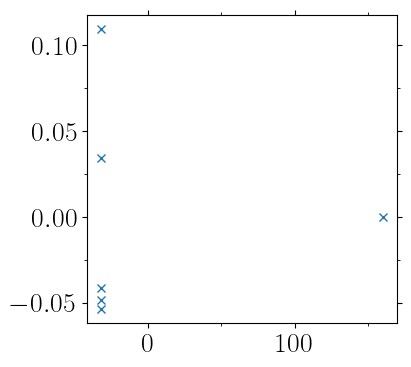

In [9]:
#--- concat. data
X = data.descriptors #np.concatenate([data.descriptors,np.c_[data.descriptors_defect_free].T],axis=0)

pca = PCA(n_components=2,random_state=123)
pca.fit(X)
X_transformed = pca.transform(X)

ax = utl.PltErr(X_transformed[:,0],X_transformed[:,1],
          attrs={'fmt':'x'},
                Plot = False,
          )

# utl.PltErr(X_transformed[-1,0],X_transformed[-1,1],
#           attrs={'fmt':'.'},
#            ax=ax,
#           )

In [ ]:
X_transformed[:-1].shape

In [ ]:
np.c_[data.descriptors_defect_free].shape

In [ ]:

X, y = data.descriptors, np.c_[data.events_id_energy['barrier']] #make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,)# random_state=1)
regr = MLPRegressor(max_iter=500).fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)




In [ ]:
ax = utl.PltErr(None,None,Plot=False)

utl.PltErr(y_test,y_pred_test,
           attrs={'fmt':'.','color':'C0'},
           ax=ax,
           Plot=False,
          )

utl.PltErr(y_train,y_pred_train,
           attrs={'fmt':'x','color':'red'},
           ax=ax,
           Plot=False
          )

utl.PltErr(None,None,
          xlim=(-1,4),
          ylim=(-1,4),
           xstr=r'$E_\mathrm{act}$',
           ystr=r'$E_\mathrm{pred}$',
           ax=ax,
           Plot=False
          )
